In [1]:
import numpy as np
data_a = np.loadtxt('tr1.txt')
data_b = np.loadtxt('tr2.txt')
sample_rate=200.0

t_before=0.05
t_after=0.2
cc_maxlag=0.1
plot=True
filter="bandpass"
filter_options={'freqmin': 1, 'freqmax': 10}

In [2]:
from obspy import Trace
import scipy

In [3]:
def correlate(a, b, shift, demean=True, normalize='naive', method='auto'):
    """
    Cross-correlation of two signals up to a specified maximal shift.

    This function only allows 'naive' normalization with the overall
    standard deviations. This is a reasonable approximation for signals of
    similar length and a relatively small shift parameter
    (e.g. noise cross-correlation).
    If you are interested in the full cross-correlation function better use
    :func:`~obspy.signal.cross_correlation.correlate_template` which also
    provides correct normalization.

    :type a: :class:`~numpy.ndarray`, :class:`~obspy.core.trace.Trace`
    :param a: first signal
    :type b: :class:`~numpy.ndarray`, :class:`~obspy.core.trace.Trace`
    :param b: second signal to correlate with first signal
    :param int shift: Number of samples to shift for cross correlation.
        The cross-correlation will consist of ``2*shift+1`` or
        ``2*shift`` samples. The sample with zero shift will be in the middle.
    :param bool demean: Demean data beforehand.
    :param normalize: Method for normalization of cross-correlation.
        One of ``'naive'`` or ``None``
        (``True`` and ``False`` are supported for backwards compatibility).
        ``'naive'`` normalizes by the overall standard deviation.
        ``None`` does not normalize.
    :param str method: Method to use to calculate the correlation.
         ``'direct'``: The correlation is determined directly from sums,
         the definition of correlation.
         ``'fft'`` The Fast Fourier Transform is used to perform the
         correlation more quickly.
         ``'auto'`` Automatically chooses direct or Fourier method based on an
         estimate of which is faster. (Only availlable for SciPy versions >=
         0.19. For older Scipy version method defaults to ``'fft'``.)

    :return: cross-correlation function.

    To calculate shift and value of the maximum of the returned
    cross-correlation function use
    :func:`~obspy.signal.cross_correlation.xcorr_max`.

    .. note::

        For most input parameters cross-correlation using the FFT is much
        faster.
        Only for small values of ``shift`` (approximately less than 100)
        direct time domain cross-correlation migth save some time.

    .. note::

        If the signals have different length, they will be aligned around
        their middle. The sample with zero shift in the cross-correlation
        function corresponds to this correlation:

        ::

            --aaaa--
            bbbbbbbb

        For odd ``len(a)-len(b)`` the cross-correlation function will
        consist of only ``2*shift`` samples because a shift of 0
        corresponds to the middle between two samples.

    .. rubric:: Example

    >>> from obspy import read
    >>> a = read()[0][450:550]
    >>> b = a[:-2]
    >>> cc = correlate(a, b, 2)
    >>> cc
    array([ 0.62390515,  0.99630851,  0.62187106, -0.05864797, -0.41496995])
    >>> shift, value = xcorr_max(cc)
    >>> shift
    -1
    >>> round(value, 3)
    0.996
    """
    if normalize is False:
        normalize = None
    if normalize is True:
        normalize = 'naive'
    # if we get Trace objects, use their data arrays
    if isinstance(a, Trace):
        a = a.data
    if isinstance(b, Trace):
        b = b.data
    a = np.asarray(a)
    b = np.asarray(b)
    if demean:
        a = a - np.mean(a)
        b = b - np.mean(b)
    # choose the usually faster xcorr function for each method
    _xcorr = _xcorr_padzeros if method == 'direct' else _xcorr_slice
    cc = _xcorr(a, b, shift, method)
    if normalize == 'naive':
        norm = (np.sum(a ** 2) * np.sum(b ** 2)) ** 0.5
        if norm <= np.finfo(float).eps:
            # norm is zero
            # => cross-correlation function will have only zeros
            cc[:] = 0
        elif cc.dtype == float:
            cc /= norm
        else:
            cc = cc / norm
    elif normalize is not None:
        raise ValueError("normalize has to be one of (None, 'naive'))")
    return cc


In [4]:
def _xcorr_padzeros(a, b, shift, method):
    """
    Cross-correlation using SciPy with mode='valid' and precedent zero padding.
    """
    if shift is None:
        shift = (len(a) + len(b) - 1) // 2
    dif = len(a) - len(b) - 2 * shift
    if dif > 0:
        b = _pad_zeros(b, dif // 2)
    else:
        a = _pad_zeros(a, -dif // 2)
    return scipy.signal.correlate(a, b, mode='valid', method=method)


In [5]:
def _pad_zeros(a, num, num2=None):
    """Pad num zeros at both sides of array a"""
    if num2 is None:
        num2 = num
    hstack = [np.zeros(num, dtype=a.dtype), a, np.zeros(num2, dtype=a.dtype)]
    return np.hstack(hstack)

In [6]:
from scipy import signal
import matplotlib.pyplot as plt
def simple_xcorr(data_a, data_b, samp_rate, cc_maxlag):
    # cross correlate
    shift_len = int(cc_maxlag * samp_rate)
    cc = correlate(data_a, data_b, shift_len, method='direct')
    # _cc_shift, cc_max = xcorr_max(cc)
    cc_curvature = np.concatenate((np.zeros(1), np.diff(cc, 2), np.zeros(1)))
    # cc_convex = np.ma.masked_where(np.sign(cc_curvature) >= 0, cc)
    # cc_concave = np.ma.masked_where(np.sign(cc_curvature) < 0, cc)

    # make array with time shifts in seconds corresponding to cc function
    cc_t = np.linspace(-cc_maxlag, cc_maxlag, shift_len * 2 + 1)

    # take the subportion of the cross correlation around the maximum that is
    # convex and fit a parabola.
    # use vertex as subsample resolution best cc fit.
    peak_index = cc.argmax()
    first_sample = peak_index
    # XXX this could be improved..
    while first_sample > 0 and cc_curvature[first_sample - 1] <= 0:
        first_sample -= 1
    last_sample = peak_index
    while last_sample < len(cc) - 1 and cc_curvature[last_sample + 1] <= 0:
        last_sample += 1

    # work on subarrays
    num_samples = last_sample - first_sample + 1

    # quadratic fit for small subwindow
    coeffs, residual = np.polyfit(
        cc_t[first_sample:last_sample + 1],
        cc[first_sample:last_sample + 1], deg=2, full=True)[:2]

    # X coordinate of vertex of parabola gives time shift to correct
    # differential pick time. Y coordinate gives maximum correlation
    # coefficient.
    dt = -coeffs[1] / 2.0 / coeffs[0]
    coeff = (4 * coeffs[0] * coeffs[2] - coeffs[1] ** 2) / (4 * coeffs[0])
    # this is the shift to apply on the time axis of `trace2` to align the
    # traces. Actually we do not want to shift the trace to align it but we
    # want to correct the time of `pick2` so that the traces align without
    # shifting. This is the negative of the cross correlation shift.
    dt = -dt
    pick2_corr = dt

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    tmp_t = np.linspace(0, len(data_a) / samp_rate, len(data_a))
    ax1.plot(tmp_t, data_a / float(data_a.max()), "k",
             label="Trace 1")
    ax1.plot(tmp_t, data_b / float(data_b.max()), "r",
             label="Trace 2")
    ax1.plot(tmp_t - dt, data_b / float(data_b.max()),
             "g", label="Trace 2 (shifted)")
    ax1.legend(loc="lower right", prop={'size': "small"})
    ax1.set_xlabel("time [s]")
    ax1.set_ylabel("norm. amplitude")
    ax2 = fig.add_subplot(212)
    # ax2.plot(cc_t, cc_convex, ls="", marker=".", color="k",
    #          label="xcorr (convex)")
    # ax2.plot(cc_t, cc_concave, ls="", marker=".", color="0.7",
    #          label="xcorr (concave)")
    ax2.plot(cc_t[first_sample:last_sample + 1],
             cc[first_sample:last_sample + 1], "b.",
             label="used for fitting")
    tmp_t = np.linspace(cc_t[first_sample], cc_t[last_sample],
                        num_samples * 10)
    ax2.plot(tmp_t, np.polyval(coeffs, tmp_t), "b", label="fit")
    ax2.axvline(-dt, color="g", label="vertex")
    ax2.axhline(coeff, color="g")
    ax2.set_xlabel("%.2f at %.3f seconds correction" % (coeff, -dt))
    ax2.set_ylabel("correlation coefficient")
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(cc_t[0], cc_t[-1])
    ax2.legend(loc="lower right", prop={'size': "x-small"})

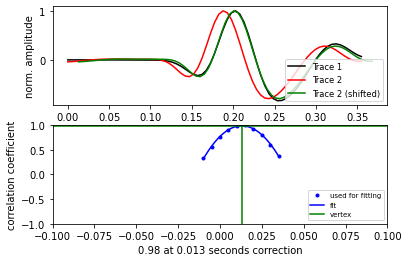

In [7]:
simple_xcorr(data_a, data_b, sample_rate, cc_maxlag)